# Лабораторная работа №5 "SVM"
## Студент: Кирпа Дмитрий
## Преподаватель: Мангараков Александр

## Подключение зависимостей

In [ ]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Набор данных

In [ ]:
data = pd.read_csv("gym_members_exercise_tracking.csv")
data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [ ]:
features = data[['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']]

scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

data[['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']
              ] = normalized_features

In [ ]:
X = data.drop(columns=['Gender'])
labelencoder = LabelEncoder()
X['Workout_Type'] = labelencoder.fit_transform(X['Workout_Type'])

In [ ]:
X = X[['Resting_BPM', 'Session_Duration (hours)']]
y = data.Experience_Level < 1

In [ ]:
y = ((y - 0.5) * 2).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head()

,Resting_BPM,Session_Duration (hours)
514,0.379198,0.447932
583,1.198501,0.622932
926,-1.669061,-1.068735
850,-1.259409,0.243765
423,0.242647,0.068765


In [ ]:
y[:10]

array([-1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.])

In [ ]:
np.unique(y, return_counts=True)

(array([-1.,  1.]), array([191, 782]))

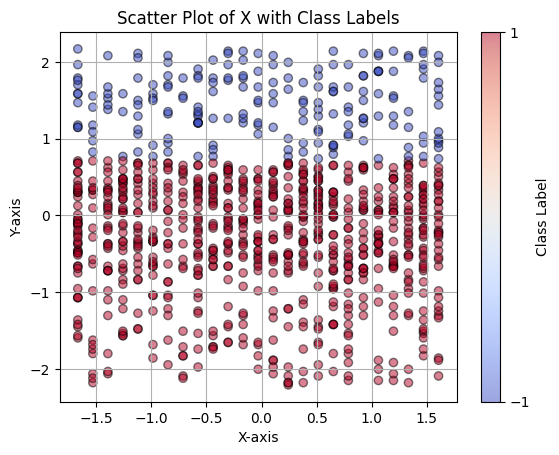

In [ ]:
scatter = plt.scatter(X.to_numpy()[:, 0], X.to_numpy()[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.5)

plt.colorbar(scatter, ticks=[-1, 1], label='Class Label')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of X with Class Labels')

plt.grid(True)
plt.show()

## SVM

### Синтетика

In [ ]:
X_synt = np.array([[1, 2], [2, 2], [3, 3], [5, 1], [1, 2], [5, 1], [0.75, 1.5], [0.5, 5.5]])
y_synt = np.array([1, 1, -1, -1, 1, -1, 1, 1])

In [ ]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def rbf_kernel(x1, x2, gamma=1.0):
    distance = np.sum((x1 - x2) ** 2)
    return np.exp(-gamma * distance)

def polynomial_kernel(x1, x2, degree=3, coef0=1):
    return (np.dot(x1, x2) + coef0) ** degree

In [ ]:
def compute_Q(X, y, kernel_function):
    l = X.shape[0]
    Q = np.zeros((l, l))
    for i in range(l):
        for j in range(l):
            Q[i, j] = y[i] * y[j] * kernel_function(X[i], X[j])
    return Q

def objective(λ, Q):
    return 0.5 * np.dot(λ, np.dot(Q, λ)) - np.sum(λ)

In [ ]:
def decision_function(X_new, X_train, y_train, λ_optimal, kernel_function, b, **kernel_params):
    decision_values = np.zeros(len(X_new))
    for i in range(len(X_new)):
        s = 0
        for alpha, y_i, x_i in zip(λ_optimal, y_train, X_train):
            if alpha > 1e-5:
                s += alpha * y_i * kernel_function(X_new[i], x_i, **kernel_params)
        decision_values[i] = s + b
    return decision_values

def svm_dual_with_visualization(X, y, kernel_function, kernel_params={}, C=1.0):
    l = X.shape[0]
    Q = compute_Q(X, y, kernel_function, **kernel_params)

    def objective(λ, Q):
        return 0.5 * np.dot(λ, np.dot(Q, λ)) - np.sum(λ)

    bounds = [(0, C) for _ in range(len(y))]
    cons = {'type': 'eq', 'fun': lambda λ: np.dot(λ, y)}
    initial_λ = np.zeros(len(y))

    result = minimize(fun=objective,
                      x0=initial_λ,
                      args=(Q,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=cons)

    λ_optimal = result.x

    support_vector_indices = np.where(λ_optimal > 1e-5)[0]
    support_vectors = X[support_vector_indices]

    b = 0
    for idx in support_vector_indices:
        s = 0
        for alpha, y_i, x_i in zip(λ_optimal, y, X):
            if alpha > 1e-5:
                s += alpha * y_i * kernel_function(X[idx], x_i, **kernel_params)
        b += y[idx] - s
    b /= len(support_vector_indices)

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    XX, YY = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = decision_function(xy, X, y, λ_optimal, kernel_function, b, **kernel_params)
    Z = Z.reshape(XX.shape)

    plt.contourf(XX, YY, Z, levels=[-np.inf, 0, np.inf], colors=['lightblue', 'lightcoral'], alpha=0.2)
    plt.contour(XX, YY, Z, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])

    plt.title(f'SVM with {kernel_function.__name__}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

    return λ_optimal, kernel_function, b, kernel_params

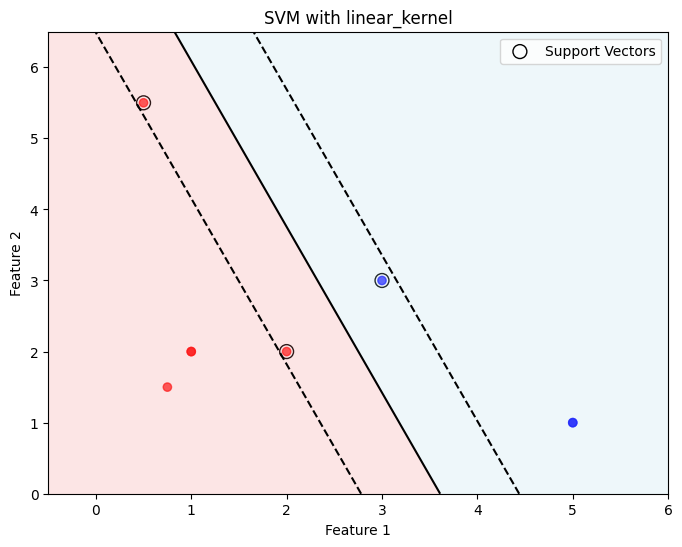

(array([1.65710686e-15, 8.62068978e-01, 1.00000000e+00, 1.20172929e-15,
        1.31207502e-15, 5.84030558e-16, 1.42940431e-15, 1.37931022e-01]),
 <function __main__.linear_kernel(x1, x2)>,
 4.356321954369519,
 {})

In [ ]:
svm_dual_with_visualization(X_synt, y_synt, linear_kernel, C=1.0)

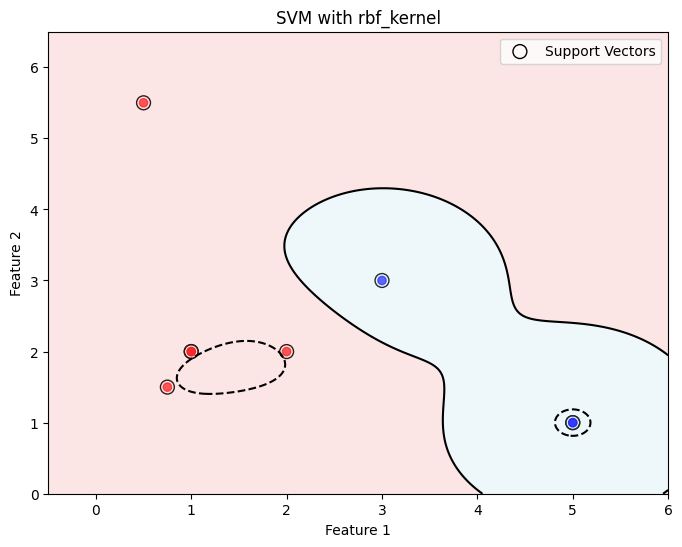

In [ ]:
svm_dual_with_visualization(X_synt, y_synt, rbf_kernel, C=1.0)

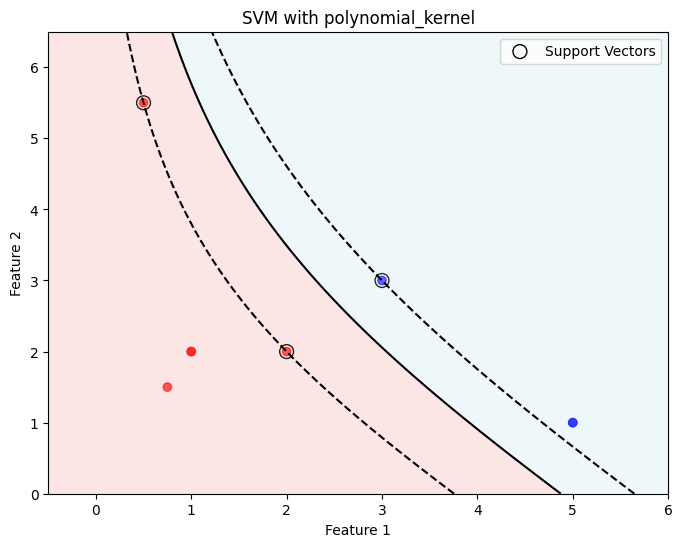

In [ ]:
svm_dual_with_visualization(X_synt, y_synt, polynomial_kernel, C=1.0)

### Реальные данные

#### Визуализация

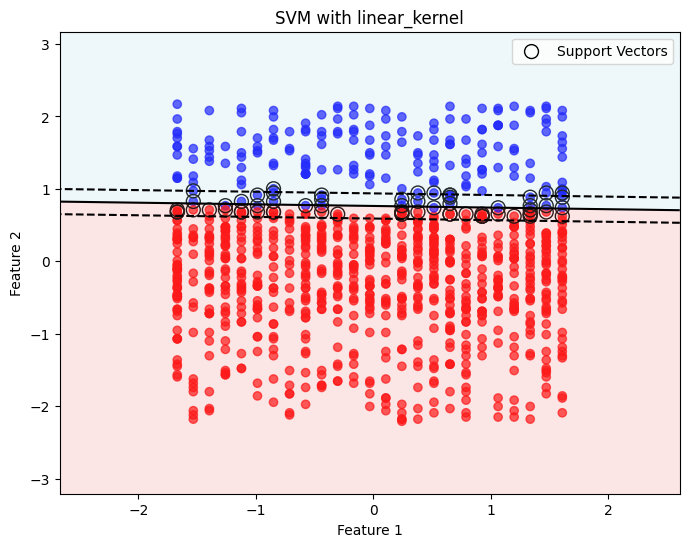

In [ ]:
svm_dual_with_visualization(X.to_numpy(), y, linear_kernel, C=1.0)

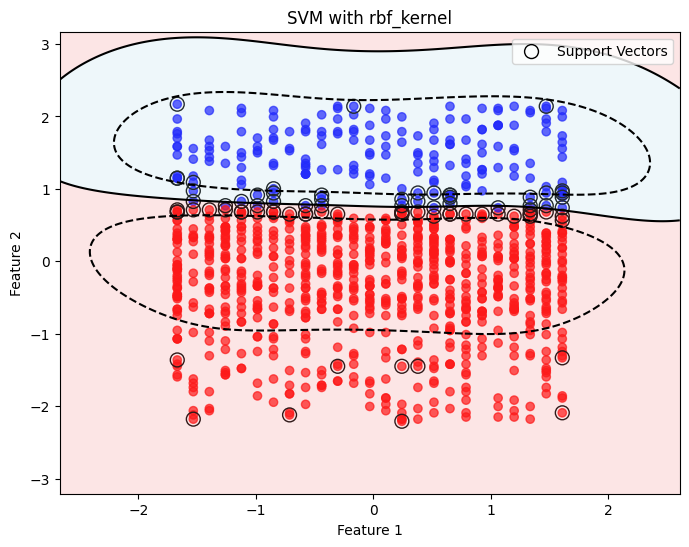

In [ ]:
svm_dual_with_visualization(X.to_numpy(), y, rbf_kernel, C=1.0)

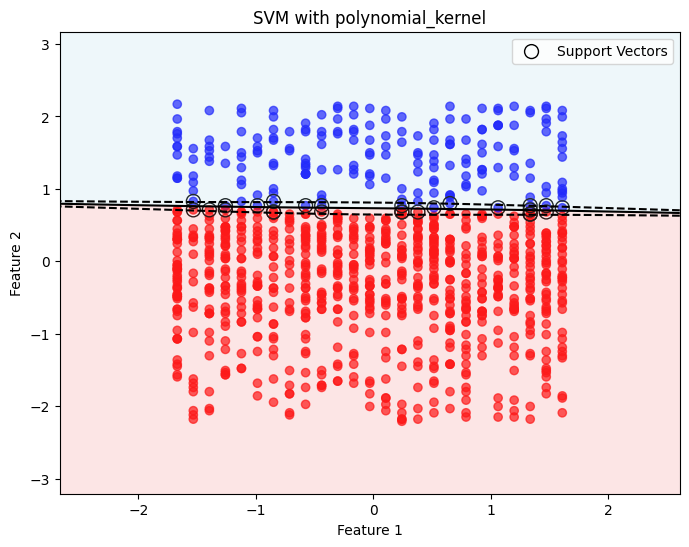

In [ ]:
svm_dual_with_visualization(X.to_numpy(), y, polynomial_kernel, C=1.0)

#### Оценка качества

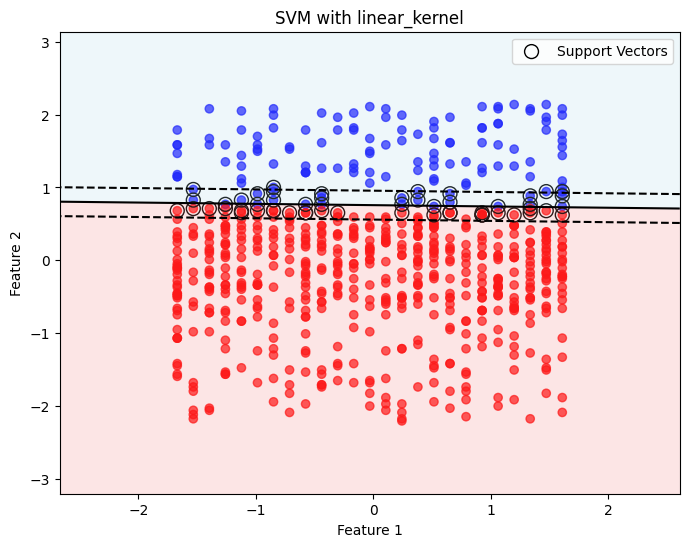

In [ ]:
λ_optimal, kernel_function, b, kernel_params = svm_dual_with_visualization(X_train.to_numpy(), y_train, linear_kernel, C=1.0)

In [ ]:
pred = decision_function(X_test.to_numpy(), X_train.to_numpy(), y_train, λ_optimal, kernel_function, b, **kernel_params)
pred[:10]

array([ 3.70631103, -5.73726791,  0.74217863,  3.8532928 , -6.93761941,
       -4.90437187,  2.08951109,  2.9836506 ,  2.3957235 ,  3.06939014])

In [ ]:
sum(((pred > 0) - 0.5) * 2 == y_test) / len(y_test)

1.0

### Библиотечное решение

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear', probability=True)

In [ ]:
clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [ ]:
sum(clf.predict(X_test) == y_test) / len(y_test)

0.9965753424657534